In [1]:
#import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn as sk
import scipy.io as sio



In [2]:
#Function Section

#Kernel Funciton 
def gaussian_kernel_h(x, x_i, bandwidth):
    d = 1
    distance = np.linalg.norm(x - x_i)
    #K_h(y/h) = h^-d k(y/h)
    kernel = (1/bandwidth**d)*((2*np.pi)**(-d/2))*np.exp((-1/2)*(distance/bandwidth)**2)
    return kernel

# Computing the leave one out
def compute_leave_one_out_cross_val(data, bandwidth):
    loocv_errors = []
    for i in range(len(data)):
        leave_out_data = np.delete(data, i,0)  # leave out data point at index i, is there a better way than using delete? 
        kde_estimate = kde(data[i], leave_out_data, bandwidth)
        squared_error = (kde_estimate - gaussian_kernel_h(data[i], data[i], bandwidth))**2
        loocv_errors.append(squared_error)
    return np.sqrt(np.mean(loocv_errors)) #return the RMSE of error

# KDE function
def kde(x, data, bandwidth):
    n = len(data)
    kde_estimate = np.zeros_like(x)
    for i in range(n):
        kde_estimate += gaussian_kernel_h(x, data[i], bandwidth)
    return kde_estimate / (n)


def compute_kernel_matrix(X, bandwidth):
    n = X.shape[0]
    # col = X.T
    # print(col.shape)
    # row = X
    # print(row.shape)
    # K = gaussian_kernel_h(col, row,bandwidth)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = gaussian_kernel_h(X[i], X[j],bandwidth)
    return K


# Least squared LOOCV algorithm
def least_squared_loocv(data):
    n = len(data)
    min_error = float('inf')
    best_bandwidth = None
    for bandwidth in np.linspace(0.01, 0.99, 100):  # Adjust the bandwidth range as needed
        first_val = 0
        #looping through the first element
        first_val=np.sum(compute_kernel_matrix(data,np.sqrt(2)*bandwidth))/(n**2)

        #loop through the second element
        second_mat = compute_kernel_matrix(data,bandwidth)
        #remove the diagonal terms, set them equal to zero
        second_mat[np.diag_indices_from(second_mat)] = 0
        second_val =( np.sum(second_mat)*2)/(n*(n-1))

        error = first_val-second_val
                
        if error < min_error:
            min_error = error
            best_bandwidth = bandwidth
    return best_bandwidth, min_error

#outlier score 1 from the document
def outlier_score_1(x, X, h):
    n = len(X)
    f_hat_x = kde(x, X, h)

    #loop through the second element
    second_mat = compute_kernel_matrix(X,h)
    #remove the diagonal terms, set them equal to zero
    second_mat[np.diag_indices_from(second_mat)] = 0
    second_val =( np.sum(second_mat))/((n-1))
    return  f_hat_x / ((1/n)*second_val)

#outlier score 2 from the document
def outlier_score_2(x, X, k):
    #get the distances from x to X matrix
    distances = np.abs(X - x)
    #sort the array dependent on the distances
    sorted_indices = np.argsort(distances)
    #pull the Kth distance for the numerator
    numerator = distances[sorted_indices[k-1]] #will pull the kth neigbor distance
    K_neighbor_array = X[sorted_indices[:k-1]] #pull the K nearest points from data X
    #Array of k neighbor distances for k neighbors
    K_list = []
    #loop through these points to get their kth neigbor distance
    for i in range(len(K_neighbor_array)):
        y = K_neighbor_array[i]
        dist = np.abs(X-y)
        sorted_ind = np.argsort(dist)
        Kth_neigh = dist[sorted_ind[k]]
        K_list.append(Kth_neigh)
    K_list = np.asarray(K_list)
    denom = (1/k)*np.sum(K_list)
    return numerator/denom


In [9]:
#Load the data

#load data from matrix file, anomaly

dataset = sio.loadmat('Data/anomaly.mat')
X = dataset['X'][0]
xtest1 = dataset['xtest1'][0][0]
xtest2 = dataset['xtest2'][0][0]
xtest3 = np.asarray([3])

#from this file we have the X value, but we need to find the density function f

print(f'xtest point1: {xtest1}')
print(f'xtest point2: {xtest2}')

print(f'X set size: {X.shape}')

xtest point1: 2.85
xtest point2: -1.5
X set size: (500,)


In [4]:
#Part A) Figure out the bandwidth parameter first

#solve for the best bandwidth for the problem
optimal_bandwidth, min_error = least_squared_loocv(X)
print('Function Value:', min_error)
print("Optimal bandwidth:", optimal_bandwidth)



Function Value: -0.4297178263881044
Optimal bandwidth: 0.07929292929292929


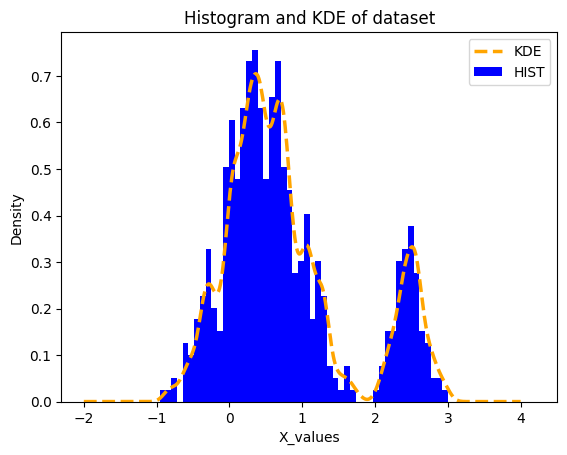

In [5]:
#Getting what the true distribution should look like
#plot the kde, from -2 to 4
x_values = np.linspace(-2, 4, 500)
kde_values = [kde(x, X, optimal_bandwidth) for x in x_values]
#Getting the histrogram for a sanity check
width = optimal_bandwidth
bin_edges = np.arange(-1,4.25,width)
hist, _ = np.histogram(X,bins=bin_edges,density=True)
# Plot histogram
plt.bar(bin_edges[:-1],hist,width=width,color='blue',label='HIST')
plt.title('Histogram and KDE of dataset')
plt.plot(x_values, kde_values,color='orange',label='KDE',linewidth='2.5',linestyle='--')
plt.xlabel('X_values')
plt.ylabel('Density')
plt.legend()
plt.savefig('Figures/Problem_6_KDEHIST.png',dpi=200)
plt.show()

In [11]:

#Part C, outlier score 1


outlier_score_xtest1 = outlier_score_1(xtest1, X, optimal_bandwidth)
outlier_score_xtest2 = outlier_score_1(xtest2, X, optimal_bandwidth)
#outlier_score_xtest3 = outlier_score_1(xtest3, X, optimal_bandwidth)
print("OutlierScore1 for xtest1:", outlier_score_xtest1)
print("OutlierScore1 for xtest2:", outlier_score_xtest2)
#print("OutlierScore1 for xtest3:", outlier_score_xtest3)


OutlierScore1 for xtest1: 0.17806559626804877
OutlierScore1 for xtest2: 5.715226670509582e-17


In [13]:

#Part F, outlier score 

k_values = [100, 150, 200]
for k in k_values:
    outlier_score_xtest1_2 = outlier_score_2(xtest1, X, k)
    outlier_score_xtest2_2 = outlier_score_2(xtest2, X, k)
    outlier_score_xtest3_2 = outlier_score_2(xtest3, X, k)
    print(f"OutlierScore2 for xtest1 (k={k}):", outlier_score_xtest1_2)
    print(f"OutlierScore2 for xtest2 (k={k}):", outlier_score_xtest2_2)
    print(f"OutlierScore3 for xtest3 (k={k}):", outlier_score_xtest3_2)


OutlierScore2 for xtest1 (k=100): 1.418756782153013
OutlierScore2 for xtest2 (k=100): 4.420915005732154
OutlierScore3 for xtest3 (k=100): 1.5572373387286196
OutlierScore2 for xtest1 (k=150): 1.7128662374537025
OutlierScore2 for xtest2 (k=150): 4.307068805909872
OutlierScore3 for xtest3 (k=150): 1.8504310233777193
OutlierScore2 for xtest1 (k=200): 1.955532464084027
OutlierScore2 for xtest2 (k=200): 3.994811265156456
OutlierScore3 for xtest3 (k=200): 2.094498614403058
